In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from  tensorflow.keras.preprocessing.sequence import pad_sequences


from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np 

import pandas as pd
from sklearn.preprocessing import OneHotEncoder

import re

In [2]:
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import vgg16
from tqdm.notebook import tqdm
from CLIP import clip # The clip model
from torchvision import transforms # Some useful image transforms
import torch.nn.functional as F # Some extra methods we might need
from tqdm.notebook import tqdm # A progress bar library

In [3]:
data = pd.read_csv('jorge_luis_borges.csv')
poems_b = data.iloc[:,1]
display(poems_b)
poems=poems_b

0     \nWas there a Garden or was the Garden a dream...
1     \nin these red labyrinths of London\nI find th...
2     \nOh destiny of Borges\nto have sailed across ...
3     \nThroughout the course of the generations\nme...
4     \nIf I could live again my life,\nIn the next;...
5     \nOf all the streets that blur in to the sunse...
6     \nFree of memory and of hope,\nlimitless, abst...
7     \nWhen sorrow lays us low\nfor a second we are...
8     \nWith lingering love she gazed at the dispers...
9     \nOh days devoted to the useless burden\nof pu...
10    \nTo gaze at a river made of time and water\nA...
11    \nA tiger comes to mind. The twilight here\nEx...
12    \nMirrors are not more silent\nnor the creepin...
13    \nWe are the time. We are the famous\nmetaphor...
Name: text, dtype: object

In [5]:
## Add data from szymborska
data_s = pd.read_csv('wislawa_szymborska.csv')
poems_s = data_s.iloc[:,1]
display(poems_s)

0     \nThere is much I owe\nto those I do not love....
1     \nWe have a soul at times.\nNo one’s got it no...
2     \n"so suddenly, who would've expected this"\n"...
3     \nSo much world all at once – how it rustles a...
4     \nWe are children of our age,\nit's a politica...
5     \n Despite the geologists’ knowledge and craft...
6     \n He looked at me, bestowing beauty,\nand I t...
7     \nNo one in this family has ever died of love....
8     \nHe came home. Said nothing.\nIt was clear, t...
9     \nWrite it. Write. In ordinary ink\non ordinar...
10    \nI am too close for him to dream about me.\nI...
11    \nIt’s good you came—she says.\nYou heard a pl...
12    \nThe buzzard never says it is to blame.\nThe ...
13    \nThey say I looked back out of curiosity.\nBu...
14    \nThey both thought\nthat a sudden feeling had...
15    \nNothing can ever happen twice.\nIn consequen...
16    \nIt can’t take a joke,\nfind a star, make a b...
17    \nTo be a boxer, or not to be there\nat al

In [6]:
poems = pd.concat([poems_b, poems_s], axis=0).reset_index(drop=True)

poems

0     \nWas there a Garden or was the Garden a dream...
1     \nin these red labyrinths of London\nI find th...
2     \nOh destiny of Borges\nto have sailed across ...
3     \nThroughout the course of the generations\nme...
4     \nIf I could live again my life,\nIn the next;...
5     \nOf all the streets that blur in to the sunse...
6     \nFree of memory and of hope,\nlimitless, abst...
7     \nWhen sorrow lays us low\nfor a second we are...
8     \nWith lingering love she gazed at the dispers...
9     \nOh days devoted to the useless burden\nof pu...
10    \nTo gaze at a river made of time and water\nA...
11    \nA tiger comes to mind. The twilight here\nEx...
12    \nMirrors are not more silent\nnor the creepin...
13    \nWe are the time. We are the famous\nmetaphor...
14    \nThere is much I owe\nto those I do not love....
15    \nWe have a soul at times.\nNo one’s got it no...
16    \n"so suddenly, who would've expected this"\n"...
17    \nSo much world all at once – how it rustl

In [7]:
# lower all words:
corpus = []
for row in poems:
    #print(row)
    line = row.lower().split('\n')
    corpus.append(line)

In [33]:
corpus

[['',
  'was there a garden or was the garden a dream?',
  'amid the fleeting light, i have slowed myself and queried,',
  'almost for consolation, if the bygone period',
  'over which this adam, wretched now, once reigned supreme,',
  'might not have been just a magical illusion',
  "of that god i dreamed. already it's imprecise",
  'in my memory, the clear paradise,',
  'but i know it exists, in flower and profusion,',
  'although not for me. my punishment for life',
  'is the stubborn earth with the incestuous strife',
  'of cains and abels and their brood; i await no pardon.',
  "yet, it's much to have loved, to have known true joy,",
  'to have had -- if only for just one day --',
  'the experience of touching the living garden.'],
 ['',
  'in these red labyrinths of london',
  'i find that i have chosen',
  'the strangest of all callings,',
  'save that, in its way, any calling is strange.',
  'like the alchemist',
  "who sought the philosopher's stone",
  'in quicksilver,',
  'i

In [8]:
for i in range(0, len(corpus)):
    for j in range(0, len(corpus[i])):
        if '\xa0' in corpus[i][j]:
            #print(corpus[i][j])
            corpus[i][j]=''
            corpus[i][j+1]=''
        elif '<' in corpus[i][j]:
            corpus[i][j]=''
        elif 'neruda' in corpus[i][j]:
            corpus[i][j]=''

In [10]:
# Get rid of the empty items of the lists and remove special characters: 
corpus_cleaned=[]
#
for i in range(0, len(corpus)):
    #corpus[i].pop(0)
    for j in range(0, len(corpus[i])):
        non_num = re.findall("([a-z]+)", corpus[i][j])
        non_num = ' '.join(non_num)
        corpus_cleaned.append(non_num)       
       
    
corpus_cleaned = [item for item in corpus_cleaned if item.strip()]

In [11]:
#Tokenize all words of the poems: Give them numbers

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus_cleaned)
total_words = len(tokenizer.word_index) + 1 ## Add one to the length of the number of words to indicate, that we 
                                            ## have an out-of-vocabulary token
word_index = tokenizer.word_index

In [12]:
corpus_cleaned

['was there a garden or was the garden a dream',
 'amid the fleeting light i have slowed myself and queried',
 'almost for consolation if the bygone period',
 'over which this adam wretched now once reigned supreme',
 'might not have been just a magical illusion',
 'of that god i dreamed already it s imprecise',
 'in my memory the clear paradise',
 'but i know it exists in flower and profusion',
 'although not for me my punishment for life',
 'is the stubborn earth with the incestuous strife',
 'of cains and abels and their brood i await no pardon',
 'yet it s much to have loved to have known true joy',
 'to have had if only for just one day',
 'the experience of touching the living garden',
 'in these red labyrinths of london',
 'i find that i have chosen',
 'the strangest of all callings',
 'save that in its way any calling is strange',
 'like the alchemist',
 'who sought the philosopher s stone',
 'in quicksilver',
 'i shall make everyday words',
 'the gambler s marked cards the com

In [13]:
#Tokenize all words of the poems: Give them numbers

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus_cleaned)
total_words = len(tokenizer.word_index) + 1 ## Add one to the length of the number of words to indicate, that we 
                                            ## have an out-of-vocabulary token
word_index = tokenizer.word_index

In [34]:
print(total_words)
print(word_index)

2210
{'the': 1, 'and': 2, 'a': 3, 'of': 4, 'to': 5, 'i': 6, 'in': 7, 'it': 8, 'that': 9, 'for': 10, 's': 11, 'is': 12, 't': 13, 'not': 14, 'my': 15, 'be': 16, 'with': 17, 'on': 18, 'we': 19, 'one': 20, 'you': 21, 'have': 22, 'all': 23, 'or': 24, 'they': 25, 'from': 26, 'me': 27, 'but': 28, 'at': 29, 'are': 30, 'this': 31, 'was': 32, 'as': 33, 'their': 34, 'no': 35, 'his': 36, 'what': 37, 'its': 38, 'if': 39, 'like': 40, 'so': 41, 'll': 42, 'who': 43, 'will': 44, 'more': 45, 'there': 46, 'us': 47, 'he': 48, 'only': 49, 'our': 50, 'don': 51, 'when': 52, 'by': 53, 'without': 54, 'him': 55, 'them': 56, 'which': 57, 'know': 58, 'can': 59, 'some': 60, 'now': 61, 'love': 62, 'an': 63, 'even': 64, 'life': 65, 'time': 66, 'too': 67, 'how': 68, 'never': 69, 'dream': 70, 'much': 71, 'am': 72, 'could': 73, 'back': 74, 'just': 75, 'where': 76, 'up': 77, 'were': 78, 'day': 79, 'nothing': 80, 're': 81, 'had': 82, 'way': 83, 'shall': 84, 'two': 85, 'those': 86, 'death': 87, 'your': 88, 'into': 89, 'he

In [14]:
input_sequences = []

for line in corpus_cleaned:
    token_list = tokenizer.texts_to_sequences([line])[0]## Creates a sequence of numbers for every line
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]     ## This creates for each line a series of sequences with
        print(n_gram_sequence)                                       ## only some of the words: word 1 and 2 for the first
                                               ## sequence, word 1, 2 and 3 for the next and so on
        input_sequences.append(n_gram_sequence)

[32, 46]
[32, 46, 3]
[32, 46, 3, 183]
[32, 46, 3, 183, 24]
[32, 46, 3, 183, 24, 32]
[32, 46, 3, 183, 24, 32, 1]
[32, 46, 3, 183, 24, 32, 1, 183]
[32, 46, 3, 183, 24, 32, 1, 183, 3]
[32, 46, 3, 183, 24, 32, 1, 183, 3, 70]
[708, 1]
[708, 1, 416]
[708, 1, 416, 138]
[708, 1, 416, 138, 6]
[708, 1, 416, 138, 6, 22]
[708, 1, 416, 138, 6, 22, 709]
[708, 1, 416, 138, 6, 22, 709, 286]
[708, 1, 416, 138, 6, 22, 709, 286, 2]
[708, 1, 416, 138, 6, 22, 709, 286, 2, 710]
[223, 10]
[223, 10, 711]
[223, 10, 711, 39]
[223, 10, 711, 39, 1]
[223, 10, 711, 39, 1, 712]
[223, 10, 711, 39, 1, 712, 713]
[92, 57]
[92, 57, 31]
[92, 57, 31, 714]
[92, 57, 31, 714, 715]
[92, 57, 31, 714, 715, 61]
[92, 57, 31, 714, 715, 61, 155]
[92, 57, 31, 714, 715, 61, 155, 716]
[92, 57, 31, 714, 715, 61, 155, 716, 717]
[184, 14]
[184, 14, 22]
[184, 14, 22, 105]
[184, 14, 22, 105, 75]
[184, 14, 22, 105, 75, 3]
[184, 14, 22, 105, 75, 3, 718]
[184, 14, 22, 105, 75, 3, 718, 719]
[4, 9]
[4, 9, 224]
[4, 9, 224, 6]
[4, 9, 224, 6, 720]


[2, 1, 530, 4, 185, 4, 140, 2]
[2, 1, 530, 4, 185, 4, 140, 2, 1026]
[2, 1]
[2, 1, 1027]
[2, 1, 1027, 4]
[2, 1, 1027, 4, 1]
[2, 1, 1027, 4, 1, 531]
[2, 1, 1027, 4, 1, 531, 57]
[2, 1, 1027, 4, 1, 531, 57, 1]
[2, 1, 1027, 4, 1, 531, 57, 1, 1028]
[2, 1, 1027, 4, 1, 531, 57, 1, 1028, 1029]
[4, 1]
[4, 1, 532]
[4, 1, 532, 531]
[4, 1, 532, 531, 149]
[4, 1, 532, 531, 149, 14]
[4, 1, 532, 531, 149, 14, 533]
[4, 1, 532, 531, 149, 14, 533, 1030]
[2, 252]
[2, 252, 1031]
[2, 252, 1031, 17]
[2, 252, 1031, 17, 248]
[2, 252, 1031, 17, 248, 24]
[2, 252, 1031, 17, 248, 24, 1032]
[2, 1]
[2, 1, 1033]
[2, 1, 1033, 4]
[2, 1, 1033, 4, 1034]
[2, 1]
[2, 1, 1035]
[2, 1, 1035, 4]
[2, 1, 1035, 4, 1036]
[2, 1, 1035, 4, 1036, 443]
[2, 1, 1035, 4, 1036, 443, 1037]
[2, 1]
[2, 1, 202]
[2, 1, 202, 9]
[2, 1, 202, 9, 102]
[2, 1, 202, 9, 102, 1038]
[2, 1, 202, 9, 102, 1038, 47]
[2, 1, 202, 9, 102, 1038, 47, 53]
[2, 1, 202, 9, 102, 1038, 47, 53, 1039]
[2, 9]
[2, 9, 1040]
[2, 9, 1040, 4]
[2, 9, 1040, 4, 23]
[2, 9, 1040, 4, 2

[68, 5, 1325, 17, 1, 1326, 1327]
[68, 5, 1325, 17, 1, 1326, 1327, 1328]
[1329, 1330]
[1329, 1330, 3]
[1329, 1330, 3, 1331]
[1329, 1330, 3, 1331, 28]
[1329, 1330, 3, 1331, 28, 1332]
[1329, 1330, 3, 1331, 28, 1332, 7]
[1329, 1330, 3, 1331, 28, 1332, 7, 1333]
[37, 120]
[37, 120, 1334]
[37, 120, 1334, 37]
[37, 120, 1334, 37, 120]
[37, 120, 1334, 37, 120, 1335]
[6, 73]
[6, 73, 212]
[6, 73, 212, 89]
[6, 73, 212, 89, 1336]
[6, 73, 212, 89, 1336, 28]
[6, 73, 212, 89, 1336, 28, 51]
[6, 73, 212, 89, 1336, 28, 51, 13]
[6, 73, 212, 89, 1336, 28, 51, 13, 22]
[6, 73, 212, 89, 1336, 28, 51, 13, 22, 1]
[6, 73, 212, 89, 1336, 28, 51, 13, 22, 1, 519]
[96, 30]
[96, 30, 1337]
[96, 30, 1337, 6]
[96, 30, 1337, 6, 75]
[96, 30, 1337, 6, 75, 59]
[96, 30, 1337, 6, 75, 59, 13]
[96, 30, 1337, 6, 75, 59, 13, 1338]
[96, 30, 1337, 6, 75, 59, 13, 1338, 51]
[96, 30, 1337, 6, 75, 59, 13, 1338, 51, 13]
[96, 30, 1337, 6, 75, 59, 13, 1338, 51, 13, 1339]
[604, 13]
[604, 13, 195]
[604, 13, 195, 3]
[604, 13, 195, 3, 218]
[60

[54, 15, 291, 10, 217]
[54, 15, 291, 10, 217, 67]
[54, 15, 291, 10, 217, 67, 95]
[10, 3]
[10, 3, 509]
[10, 3, 509, 1639]
[10, 3, 509, 1639, 26]
[10, 3, 509, 1639, 26, 15]
[10, 3, 509, 1639, 26, 15, 403]
[10, 3, 509, 1639, 26, 15, 403, 5]
[10, 3, 509, 1639, 26, 15, 403, 5, 1640]
[67, 95]
[67, 95, 10]
[67, 95, 10, 27]
[67, 95, 10, 27, 5]
[67, 95, 10, 27, 5, 1641]
[67, 95, 10, 27, 5, 1641, 33]
[67, 95, 10, 27, 5, 1641, 33, 3]
[67, 95, 10, 27, 5, 1641, 33, 3, 1642]
[329, 196]
[329, 196, 1]
[329, 196, 1, 273]
[329, 196, 1, 273, 233]
[69, 128]
[69, 128, 44]
[69, 128, 44, 6]
[69, 128, 44, 6, 396]
[69, 128, 44, 6, 396, 41]
[69, 128, 44, 6, 396, 41, 1643]
[41, 177]
[41, 177, 246]
[41, 177, 246, 1]
[41, 177, 246, 1, 356]
[41, 177, 246, 1, 356, 41]
[41, 177, 246, 1, 356, 41, 1644]
[33, 155]
[33, 155, 7]
[33, 155, 7, 36]
[33, 155, 7, 36, 70]
[33, 155, 7, 36, 70, 6]
[33, 155, 7, 36, 70, 6, 72]
[33, 155, 7, 36, 70, 6, 72, 67]
[33, 155, 7, 36, 70, 6, 72, 67, 95]
[67, 95]
[67, 95, 6]
[67, 95, 6, 332]


[20, 222, 1974, 2, 1, 498, 593]
[20, 222]
[20, 222, 63]
[20, 222, 63, 124]
[20, 222, 63, 124, 1975]
[20, 222]
[20, 222, 587]
[20, 222, 587, 1]
[20, 222, 587, 1, 1976]
[20, 222, 587, 1, 1976, 134]
[20, 222]
[20, 222, 1977]
[20, 222, 1977, 3]
[20, 222, 1977, 3, 1978]
[28, 37]
[28, 37, 12]
[28, 37, 12, 208]
[141, 1979]
[141, 1979, 697]
[22, 105]
[22, 105, 147]
[22, 105, 147, 5]
[22, 105, 147, 5, 31]
[22, 105, 147, 5, 31, 384]
[28, 6]
[28, 6, 51]
[28, 6, 51, 13]
[28, 6, 51, 13, 58]
[28, 6, 51, 13, 58, 2]
[28, 6, 51, 13, 58, 2, 51]
[28, 6, 51, 13, 58, 2, 51, 13]
[28, 6, 51, 13, 58, 2, 51, 13, 58]
[28, 6, 51, 13, 58, 2, 51, 13, 58, 2]
[28, 6, 51, 13, 58, 2, 51, 13, 58, 2, 257]
[28, 6, 51, 13, 58, 2, 51, 13, 58, 2, 257, 18]
[28, 6, 51, 13, 58, 2, 51, 13, 58, 2, 257, 18, 5]
[28, 6, 51, 13, 58, 2, 51, 13, 58, 2, 257, 18, 5, 8]
[40, 5]
[40, 5, 3]
[40, 5, 3, 1980]
[40, 5, 3, 1980, 1981]
[60, 114]
[60, 114, 655]
[60, 114, 655, 60]
[60, 114, 655, 60, 176]
[60, 114, 655, 60, 176, 114]
[7, 60]
[7, 60

In [15]:
len(input_sequences)

6441

In [16]:
#Pad the input_sequences:

max_sequence_len = max([len(x) for x in input_sequences])   ## Find the maximum length of the sequences 

padding_style='pre'

input_sequences = np.array(pad_sequences(input_sequences,         ## Pad everything with zeros up to the maximum length sentence
                                         maxlen=max_sequence_len, 
                                         padding=padding_style))

In [17]:
## Split into y and X; y is always the last number in the list

xs = input_sequences[:, :-1]
labels = input_sequences[:, -1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words) ## so we can one-hot-encode the labels

In [18]:
ys.shape

(6441, 2210)

In [20]:
%%time
model = Sequential()
model.add(Embedding(total_words, 100, input_length = max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
#model.add(Dense(total_words/2, activation='relu'))
model.add(Dense(total_words, activation='softmax'))
adam = Adam()
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=100, verbose=1)

Epoch 1/100
202/202 [==============================] - 19s 56ms/step - loss: 6.9124 - accuracy: 0.0491
Epoch 2/100
202/202 [==============================] - 12s 58ms/step - loss: 6.3891 - accuracy: 0.0576
Epoch 3/100
202/202 [==============================] - 11s 56ms/step - loss: 6.2093 - accuracy: 0.0637
Epoch 4/100
202/202 [==============================] - 12s 59ms/step - loss: 6.0660 - accuracy: 0.0706
Epoch 5/100
202/202 [==============================] - 12s 57ms/step - loss: 5.9482 - accuracy: 0.0750
Epoch 6/100
202/202 [==============================] - 12s 59ms/step - loss: 5.8325 - accuracy: 0.0810
Epoch 7/100
202/202 [==============================] - 11s 57ms/step - loss: 5.7335 - accuracy: 0.0854
Epoch 8/100
202/202 [==============================] - 12s 58ms/step - loss: 5.6384 - accuracy: 0.0879
Epoch 9/100
202/202 [==============================] - 12s 58ms/step - loss: 5.5588 - accuracy: 0.0904
Epoch 10/100
202/202 [==============================] - 12s 57ms/step - l

202/202 [==============================] - 12s 58ms/step - loss: 1.7669 - accuracy: 0.6184
Epoch 80/100
202/202 [==============================] - 11s 56ms/step - loss: 1.7483 - accuracy: 0.6258
Epoch 81/100
202/202 [==============================] - 12s 57ms/step - loss: 1.7237 - accuracy: 0.6334
Epoch 82/100
202/202 [==============================] - 11s 57ms/step - loss: 1.6937 - accuracy: 0.6398
Epoch 83/100
202/202 [==============================] - 11s 57ms/step - loss: 1.6711 - accuracy: 0.6407
Epoch 84/100
202/202 [==============================] - 12s 58ms/step - loss: 1.6462 - accuracy: 0.6497
Epoch 85/100
202/202 [==============================] - 12s 61ms/step - loss: 1.6366 - accuracy: 0.6504
Epoch 86/100
202/202 [==============================] - 13s 63ms/step - loss: 1.6015 - accuracy: 0.6591
Epoch 87/100
202/202 [==============================] - 13s 65ms/step - loss: 1.5827 - accuracy: 0.6648
Epoch 88/100
202/202 [==============================] - 13s 67ms/step - loss:

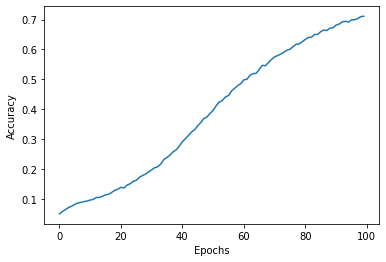

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [22]:
model.save('models/bi_lstm')

INFO:tensorflow:Assets written to: models/bi_lstm\assets


INFO:tensorflow:Assets written to: models/bi_lstm\assets


In [71]:
chmod 777 University

SyntaxError: invalid syntax (210621211.py, line 1)

In [79]:
import pickle

# open a file, where you ant to store the data
#file = open('history_bi_lstm.p', 'wb')
#file = open('history_more_layers_70.p', 'rb')
# dump information to that file
#pickle.dump(history.history, file)
with open((r'C:/Users/duyadong/Ironhack/Week_9/models/bi_lstm'), 'rb') as file:
    model = pickle.load(file)
# close the file
file.close()

PermissionError: [Errno 13] Permission denied: 'C:/Users/duyadong/Ironhack/Week_9/models/bi_lstm'

In [92]:
model = keras.models.load_model('models/bi_lstm')

In [93]:
model

In [63]:
#history = model.fit(xs, ys, epochs=100, verbose=1)

AttributeError: 'dict' object has no attribute 'fit'

In [100]:
seed_text = "under the sunshine"
next_words = 20

output_index = [0,0,0]
output_word = [0,0,0]
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    print(predicted[0])
    print(output_index[-1], output_index[-2])
    
    # if-clauses I added, because otherwise the model sometimes gives the same word several times in a row:
    if predicted[0] == output_index[-1]:
        predicted = np.argsort(model.predict(token_list), axis=-1)[0][-2]
    
    # also this. Otherwise it sometimes gives a pair of two words several times in a row:
    if (predicted[0] == output_index[-2]) & (output_word[-1]==output_word[-3]):
        predicted = np.argsort(model.predict(token_list), axis=-1)[0][-2]
    #print(model.predict(token_list))
     
    
    #output_word = [0,0,0]
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word.append(word)
            output_index.append(index)
            break
    seed_text += " " + output_word[-1]
print(seed_text)

1/1 [==============================] - 0s 25ms/step
820
0 0
1/1 [==============================] - 0s 23ms/step
4
820 0
1/1 [==============================] - 0s 27ms/step
305
4 820
1/1 [==============================] - 0s 24ms/step
36
305 4
1/1 [==============================] - 0s 30ms/step
114
36 305
1/1 [==============================] - 0s 24ms/step
2
114 36
1/1 [==============================] - 0s 22ms/step
36
2 114
1/1 [==============================] - 0s 30ms/step
232
36 2
1/1 [==============================] - 0s 24ms/step
4
232 36
1/1 [==============================] - 0s 23ms/step
439
4 232
1/1 [==============================] - 0s 24ms/step
1578
439 4
1/1 [==============================] - 0s 32ms/step
18
1578 439
1/1 [==============================] - 0s 31ms/step
1
18 1578
1/1 [==============================] - 0s 23ms/step
405
1 18
1/1 [==============================] - 0s 22ms/step
4
405 1
1/1 [==============================] - 0s 23ms/step
1772
4 405
1/1 [==========

In [40]:
predicted

array([333], dtype=int64)

In [41]:
print('Installing a few libraries')
#!git clone https://github.com/CompVis/taming-transformers &> /dev/null
#!pip install einops                                       &> /dev/null
from omegaconf import OmegaConf
import sys
sys.path.append('./taming_transformers')
from taming_transformers.taming.models import cond_transformer, vqgan

def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply

def vector_quantize(x, codebook):
  d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
  indices = d.argmin(-1)
  x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
  return replace_grad(x_q, x)

def synth(z):
  z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
  return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

def rand_z(width, height):
  f = 2**(model.decoder.num_resolutions - 1)
  toksX, toksY = width // f, height // f
  n_toks = model.quantize.n_e
  one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
  z = one_hot @ model.quantize.embedding.weight
  z = z.view([-1, toksY, toksX, model.quantize.e_dim]).permute(0, 3, 1, 2)
  return z

Installing a few libraries


In [42]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = load_vqgan_model('vqgan_imagenet_f16_16384.yaml', 'vqgan_imagenet_f16_16384.ckpt').to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


C:\Users\duyadong\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\duyadong\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips\vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


In [43]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [44]:
# Load in one of the models from CLIP
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
perceptor = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)
print(perceptor.visual.input_resolution) # 224px a side

224


In [45]:
def clip_loss(im_embed, text_embed):
  im_normed = F.normalize(im_embed.unsqueeze(1), dim=2)
  text_normed = F.normalize(text_embed.unsqueeze(0), dim=2)
  dists = im_normed.sub(text_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
  return dists.mean()

In [46]:
# Create a transform - this will map the image data to the same range as that seen by CLIP during training
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],std=[0.26862954, 0.26130258, 0.27577711])

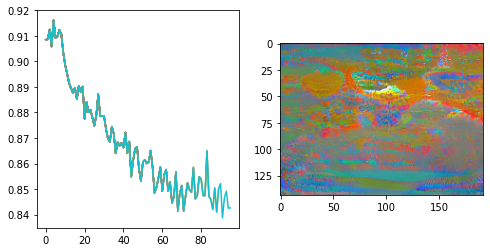

In [47]:
#prompt_text = "A colorful painting of a jellyfish by a coral reef, trending on artstation " 
prompt_text =seed_text#@param
width = 200 #@param
height = 150 #@param
lr = 0.1 #@param
n_iter = 100 #@param
crops_per_iteration = 8 #@param

# The transforms to get variations of our image
tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
    transforms.GaussianBlur(5),
])

# The z we'll be optimizing
z = rand_z(width, height)
z.requires_grad=True

# The text target
text_embed = perceptor.encode_text(clip.tokenize(prompt_text).to(device)).float()

# The optimizer - feel free to try different ones here
optimizer = torch.optim.Adam([z], lr=lr, weight_decay=1e-6)

losses = [] # Keep track of our losses (RMSE values)

# A folder to save results
#!rm -r steps
#!mkdir steps


# Display for showing progress
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
p = display(fig, display_id=True)

# The optimization loop:
for i in tqdm(range(n_iter)):

  # Reset everything related to gradient calculations
  optimizer.zero_grad()

  # Get the GAN output
  output = synth(z)

  # Calculate our loss across several different random crops/transforms
  loss = 0
  for _ in range(crops_per_iteration):
    image_embed = perceptor.encode_image(tfms(normalize(output)).to(device)).float()
    loss += clip_loss(image_embed, text_embed)/crops_per_iteration

  # Store loss
  losses.append(loss.detach().item())

  # Save image
  im_arr = np.array(output.cpu().squeeze().detach().permute(1, 2, 0)*255).astype(np.uint8)
  Image.fromarray(im_arr).save(f'steps/{i:04}.jpeg')

  # Update plots 
  if i % 5 == 0: # Saving time
    axs[0].plot(losses)
    axs[1].imshow(im_arr)
    p.update(fig)

  # Backpropagate the loss and use it to update the parameters
  loss.backward() # This does all the gradient calculations
  optimizer.step() # The optimizer does the update

ipd.clear_output()

In [101]:
!pip install streamlit

In [103]:
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
from PIL import Image

st.write("""
# Poem and image generator
***
""")
sequence = st.text_area("Sequence input", seed_text, height=250)

  command:

    streamlit run C:\Users\duyadong\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2022-09-13 22:15:41.415 
  command:

    streamlit run C:\Users\duyadong\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


<Figure size 432x288 with 0 Axes>